<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Time-series" data-toc-modified-id="Time-series-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Time series</a></span></li><li><span><a href="#Decomposed" data-toc-modified-id="Decomposed-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Decomposed</a></span></li><li><span><a href="#Weekly-seasonality" data-toc-modified-id="Weekly-seasonality-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Weekly seasonality</a></span></li><li><span><a href="#The-number-of-daily-orders" data-toc-modified-id="The-number-of-daily-orders-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>The number of daily orders</a></span></li></ul></li><li><span><a href="#Adding-Features" data-toc-modified-id="Adding-Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Adding Features</a></span><ul class="toc-item"><li><span><a href="#Hour,-dayofweek,-month" data-toc-modified-id="Hour,-dayofweek,-month-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Hour, dayofweek, month</a></span></li><li><span><a href="#Lag" data-toc-modified-id="Lag-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Lag</a></span></li><li><span><a href="#Rolling-mean" data-toc-modified-id="Rolling-mean-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Rolling mean</a></span></li></ul></li><li><span><a href="#Training-and-Evaluation." data-toc-modified-id="Training-and-Evaluation.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and Evaluation.</a></span><ul class="toc-item"><li><span><a href="#Sets" data-toc-modified-id="Sets-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Sets</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Training-and-testing" data-toc-modified-id="Training-and-testing-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Training and testing</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Final-conclusion" data-toc-modified-id="Final-conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final conclusion</a></span><ul class="toc-item"><li><span><a href="#Project-description" data-toc-modified-id="Project-description-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Project description</a></span></li><li><span><a href="#Stages" data-toc-modified-id="Stages-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Stages</a></span></li><li><span><a href="#Conclusions-and-suggestions" data-toc-modified-id="Conclusions-and-suggestions-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Conclusions and suggestions</a></span></li></ul></li></ul></div>

#  Taxi Order Prediction

The company "Chyotenkoye Taxi" has gathered historical data on taxi orders at airports. To attract more drivers during peak hours, it is necessary to forecast the number of taxi orders for the next hour. Build a model for this prediction.

The RMSE metric on the test set should not exceed 48.

You need to:

1. Load the data and resample it hourly.
2. Analyze the data.
3. Train different models with various hyperparameters. Create a test set that is 10% of the original data.
4. Evaluate the data on the test set and draw conclusions.

The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column (from English *number of orders*).

## Preparation

In [98]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [71]:
MAX_LAG = 24
ROLLING_MEAN_SIZE = 6

In [72]:
data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [73]:
data['num_orders'] = data['num_orders'].astype('int32')

In [74]:
print(data.info())
print(data.head())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int32
dtypes: int32(1)
memory usage: 51.8 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<div class="alert alert-info">
    
The table has been loaded and resampled to an hourly frequency (the task requires predicting for the next hour). It contains 4416 rows with data on the number of orders every 10 minutes from March 1, 2018, to August 31, 2018.

The data looks reliable:
1. The maximum number of orders per hour is 462, which is plausible after the arrival of a couple of large airplanes; the minimum is 0.
2. On average, there are 84.4 orders per hour.

The `num_orders` column has been converted to `int32` for optimization purposes.

## Analysis

### Time series

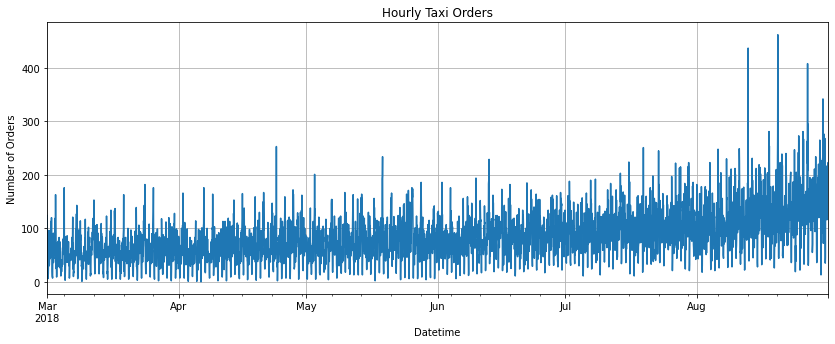

In [75]:
plt.figure(figsize=(14, 5))
data['num_orders'].plot(title='Hourly Taxi Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

<div class="alert alert-info">
    
There is an observed increase in the number of orders from March to August. Let's take a look at the decomposition.

### Decomposed

In [76]:
decomposed = seasonal_decompose(data)

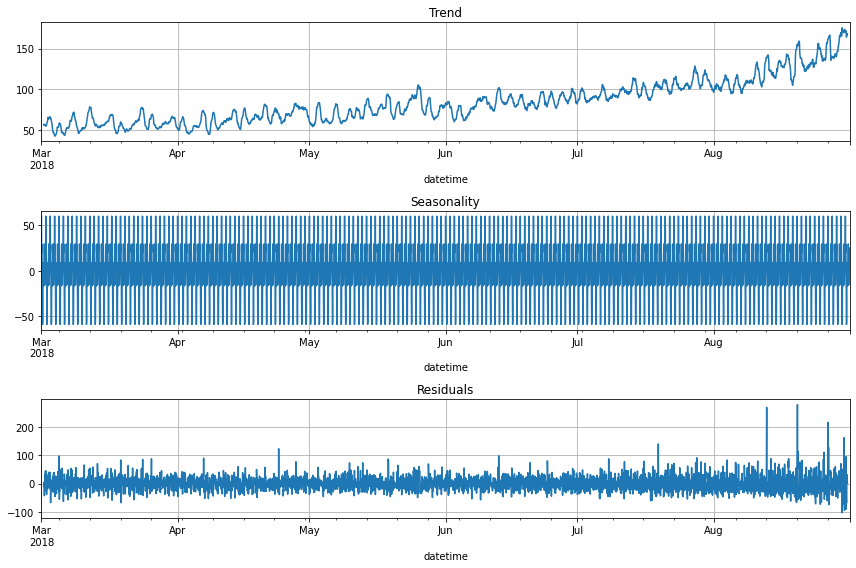

In [77]:
plt.figure(figsize=(12,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True, title='Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True, title='Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True, title='Residuals')

plt.tight_layout()

<div class="alert alert-info">
    
**Trend**: An increase in the number of orders from March to September.

**Seasonality**: There is definite seasonality, let's examine it over a shorter period.

**Residuals**: Strong fluctuations exist that are not dependent on either the trend or seasonality.

### Weekly seasonality

In [78]:
decomposed_1d = seasonal_decompose(data.resample('1D').sum())

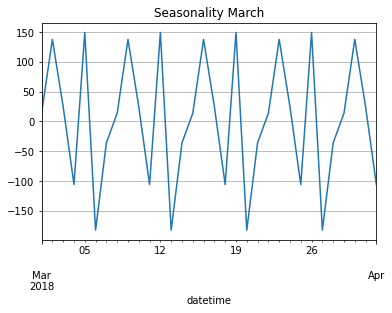

In [79]:
decomposed_1d.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca(), grid=True)
plt.title('Seasonality March')
plt.show()

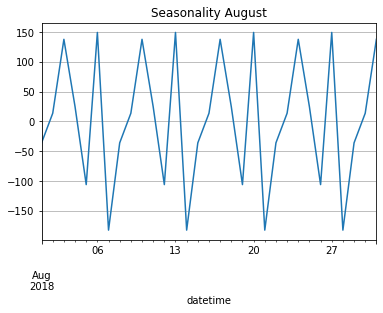

In [80]:
decomposed_1d.seasonal['2018-08-01':'2018-09-01'].plot(ax=plt.gca(), grid=True)
plt.title('Seasonality August')
plt.show()

<div class="alert alert-info">
    
There is a pattern showing the influence of the day of the week on the number of orders, regardless of the month.

### The number of daily orders

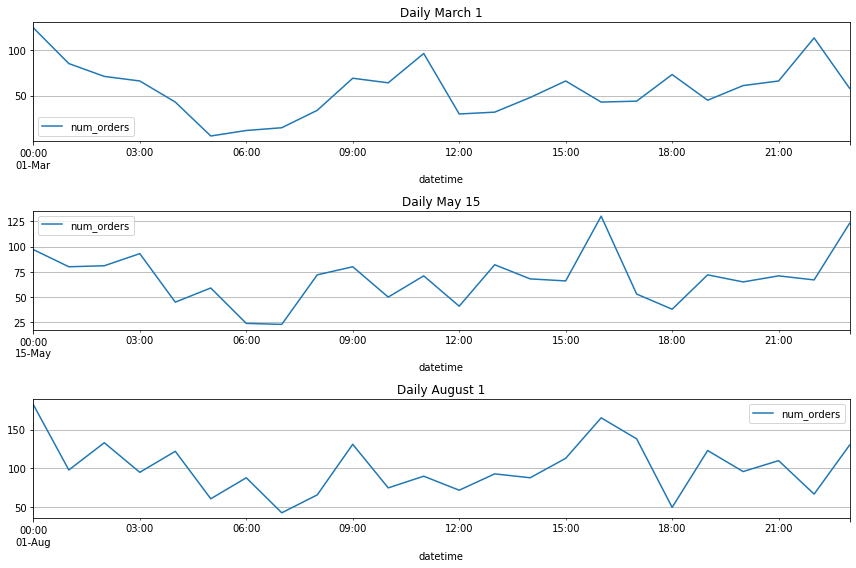

In [81]:
plt.figure(figsize = (12,8))
plt.subplot(311)
data.loc['2018-03-01'].plot(ax=plt.gca(), grid='True', title='Daily March 1')
plt.subplot(312)
data.loc['2018-05-15'].plot(ax=plt.gca(), grid='True', title='Daily May 15')
plt.subplot(313)
data.loc['2018-08-01'].plot(ax=plt.gca(), grid='True', title='Daily August 1')

plt.tight_layout()

<div class="alert alert-info">
    
There is a pattern showing the influence of the time of day on the number of orders.

## Adding Features

### Hour, dayofweek, month

In [82]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

data['month'] = data['month'].astype('category')
data['dayofweek'] = data['dayofweek'].astype('category')
data['hour'] = data['hour'].astype('category')

<div class="alert alert-info">
    
Hour, day of the week, and month all influence the number of orders, so I added these features and set them as categorical.

### Lag

In [83]:
for lag in range(1, MAX_LAG + 1):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)
data.dropna(inplace=True)

<div class="alert alert-info">
    
I added features for the 24 hours to capture the seasonality within the day.

### Rolling mean

In [84]:
data['rolling_mean'] = data['num_orders'].shift().rolling(ROLLING_MEAN_SIZE).mean()
data.dropna(inplace=True)

In [91]:
display(data.head())
display(data.info())

,num_orders,hour,dayofweek,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 09:00:00,69,9,3,3,34.0,15.0,12.0,6.0,43.0,66.0,20.333333
2018-03-01 10:00:00,64,10,3,3,69.0,34.0,15.0,12.0,6.0,43.0,39.333333
2018-03-01 11:00:00,96,11,3,3,64.0,69.0,34.0,15.0,12.0,6.0,55.666667
2018-03-01 12:00:00,30,12,3,3,96.0,64.0,69.0,34.0,15.0,12.0,76.333333
2018-03-01 13:00:00,32,13,3,3,30.0,96.0,64.0,69.0,34.0,15.0,63.333333


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4407 entries, 2018-03-01 09:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   num_orders    4407 non-null   int32   
 1   hour          4407 non-null   category
 2   dayofweek     4407 non-null   category
 3   month         4407 non-null   category
 4   lag_1         4407 non-null   float64 
 5   lag_2         4407 non-null   float64 
 6   lag_3         4407 non-null   float64 
 7   lag_4         4407 non-null   float64 
 8   lag_5         4407 non-null   float64 
 9   lag_6         4407 non-null   float64 
 10  rolling_mean  4407 non-null   float64 
dtypes: category(3), float64(7), int32(1)
memory usage: 306.9 KB


None

<div class="alert alert-info">

I added a 6-hour rolling mean. Next time will move adding new features into the function that creates new df.

## Training and Evaluation.

### Sets

In [86]:
X = data.drop('num_orders', axis=1)
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [90]:
print(X_train.shape)
print(y_train.shape)

(3966, 10)
(3966,)


### Models

In [87]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tscv = TimeSeriesSplit(n_splits=3)
models = {
    "LinearRegression": (LinearRegression(), {}, X_train_scaled, X_test_scaled),
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {"n_estimators": [100, 200], "max_depth": [5, 10]},
        X_train, X_test
    ),
    "CatBoost": (
        CatBoostRegressor(verbose=0, random_state=42),
        {"depth": [4, 6], "learning_rate": [0.03, 0.1]},
        X_train, X_test
    ),
    "LGBM": (
        LGBMRegressor(random_state=42),
        {"num_leaves": [31, 50], "learning_rate": [0.03, 0.1]},
        X_train, X_test
    )
}

### Training and testing

In [94]:
results = []
best_models = {}
for name, (model, params, X_tr, X_te) in models.items():
    print(f"\n🔄 Model train: {name}")
    start = time.time()

    if name == "CatBoost":
        cat_features = ['hour', 'dayofweek', 'month']
        best_model = model.fit(X_tr, y_train, cat_features=cat_features)
    else:
        if params:
            grid = GridSearchCV(model, param_grid=params, cv=tscv, scoring="neg_root_mean_squared_error", n_jobs=-1)
            grid.fit(X_tr, y_train)
            best_model = grid.best_estimator_
        else:
            best_model = model.fit(X_tr, y_train)
    


    end = time.time()
    elapsed = end - start

    preds = best_model.predict(X_te)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    best_models[name] = best_model
    results.append([name, rmse, elapsed])
    print(f"✅ Took {elapsed:.2f} seconds to finish. RMSE: {rmse:.2f}")



🔄 Обучение модели: LinearRegression
✅ Завершено за 0.00 секунд. RMSE: 54.07

🔄 Обучение модели: RandomForest
✅ Завершено за 10.85 секунд. RMSE: 47.27

🔄 Обучение модели: CatBoost
✅ Завершено за 4.86 секунд. RMSE: 42.85

🔄 Обучение модели: LGBM
✅ Завершено за 10.58 секунд. RMSE: 43.19


### Results

In [95]:
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "Train time (s)"])
display(results_df.sort_values("RMSE"))

,Model,RMSE,Train time (s)
2,CatBoost,42.850238,4.860506
3,LGBM,43.185060,10.578040
1,RandomForest,47.269890,10.845064
0,LinearRegression,54.072183,0.002363


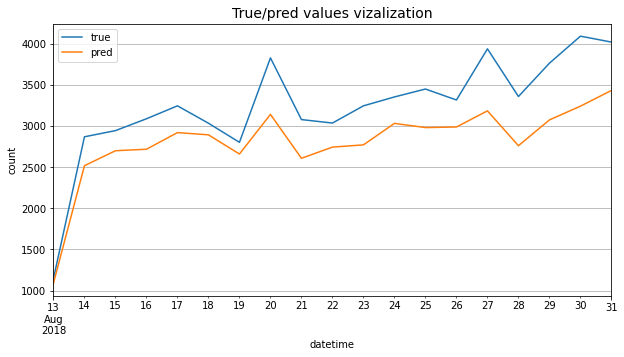

In [99]:
cat_pred = best_models['CatBoost'].predict(X_test)
df_result = pd.DataFrame(y_test)
df_result['pred'] = np.round(cat_pred, 0)
df_result.columns = ['true', 'pred']
df_result.resample('1D').sum().plot(figsize=(10, 5), grid=True)
plt.title('True/pred values vizalization', fontsize=14)
plt.ylabel('count')
plt.show()

<div class="alert alert-info">

The CatBoost model performed the best, with an RMSE of 43.

Looking at the graph, it's clear that the model captured the "idea" well, but the discrepancy increases as we move further from the last analyzed date. The accuracy of the model could likely be improved by making daily predictions and retraining with new data.

## Final conclusion

### Project description

The company "Chyotenkoye Taxi" provided historical data on the number of taxi orders at airports from March to August 2018. The goal of the project was to create a model capable of accurately predicting the number of taxi orders for the next hour.

The task required minimizing the forecasting error, expressed through the RMSE (Root Mean Squared Error) metric. The requirement was that the RMSE on the test set should not exceed 48.

As a result of the project, the best model was **CatBoost**, which achieved an RMSE of 43, meeting the given metric and allowing for accurate predictions of the number of orders for the next hour.

### Stages

1. **Data Preparation**:
   - Loaded data from the file `taxi.csv`.
   - Resampled the data to a 1-hour frequency for further analysis and prediction.
   - Converted the `num_orders` column to `int32` data type for optimization.

2. **Data Analysis**:
   - Visualized the time series and identified a trend of increasing orders from March to August.
   - Performed time series decomposition: extraction of trend, seasonality, and residuals.
   - Analyzed seasonality at different time intervals (e.g., comparison of March and August 2018).
   - Studied daily seasonality and the impact of time of day on the number of orders.

3. **Feature Engineering**:
   - Added features: hour, day of the week, and month (categorical variables).
   - Created "lag" features to account for dependencies on previous hours (up to 6 hours).
   - Calculated a 3-hour moving average to smooth the time series.

4. **Model Training and Evaluation**:
   - Split the data into training and test sets (90%/10%).
   - Applied different machine learning models (Linear Regression, Random Forest, CatBoost, LGBM) with hyperparameter tuning using GridSearch.
   - Applied data standardization using `StandardScaler`.
   - Used `TimeSeriesSplit` for cross-validation.

5. **Results**:
   - The best model was **CatBoostRegressor** with RMSE = 43.
   - The model captures the trends well, but there are discrepancies in long-term predictions.
   - The graph showed that the model's accuracy decreases as the prediction moves further from the last trained point.

### Conclusions and suggestions

- **Conclusions**:
   - The **CatBoost** model showed the best result with a minimum RMSE (43), which meets the set goal (RMSE < 48).
   - The model captured the general trends well, but the accuracy of predictions for longer periods needs improvement.

- **Suggestions**:
   - To improve the model's accuracy, it may be helpful to perform additional retraining by updating the model with new data to maintain forecast relevance.
   - It may be useful to add additional features, such as weather or events at the airport, which could affect the number of orders.